# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 14/06/2024</small></i></div>

Este notebook tiene como objetivo la definición de la última fase del modelo de difusión, es decir, el entrenamiento un modelo DDPM.

Para ello, este notebook se dividirá en las siguientes secciones:

- [0. Imports](#-0.-Imports)

- [1. Carga del dataset](#-1.-Carga-del-dataset)

- [2. Modelo](#-2.-Modelo)

  - [2.1. Entrenamiento](#21-entrenamiento)
  - [2.2 Evaluación del modelo](#22-evaluación-del-modelo)
  - [2.3 Resultados y guardado del modelo](#23-resultados-y-guardado-del-modelo)

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()``. Para implementar el training se ha usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido la funcionalidad extra que permiten guardar cada 100 epochs los pesos del modelo en un fichero con extensión `.weights.h5`. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo o para comparar la generación de muestras a lo largo del entrenamiento, entre otras cosas. Además, también se añade la posibilidad de, cada N epochs (siendo N un número determinado por el usuario), hacer una muestra donde se plotea el proceso de sampling desde $t = T$ hasta $t = 0$ y siempre partiendo desde el mismo ruido, todo ello, para ver como evoluciona el entrenamiento a lo largo de los epochs.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Este proceso de guardado se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde mas o menos se quedó sin problemas.
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
>
> Para más información: `src/model/model_callbacks`.
</small></i>

# 0. Imports

Una vez introducido el objetivo de este notebook, se importan las librerías necesarias para el desarrollo del apartado.

---

In [1]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

2024-06-15 10:04:52.949972: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 10:04:53.317902: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 10:04:55.650355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 10:04:55.697272: I external/local_xla/x

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Carga del dataset

En este apartado, se cargará el dataset que se usará para entrenar el modelo de difusión. En este caso, se usará el tf.data.Dataset creado en los notebooks anteriores. Pero con la ligera diferencia de que esta vez dividiremos dicho dataset en train y test para posteriormente al entreno del modelo evaluarlo usando el conjunto de test para garantizar el buen entrenamiento del modelo de difusión.

---

In [4]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-06-15 10:04:56.603484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-06-15 10:05:08.555132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- Train size: 3872 sprites
- Test size: 192 sprites


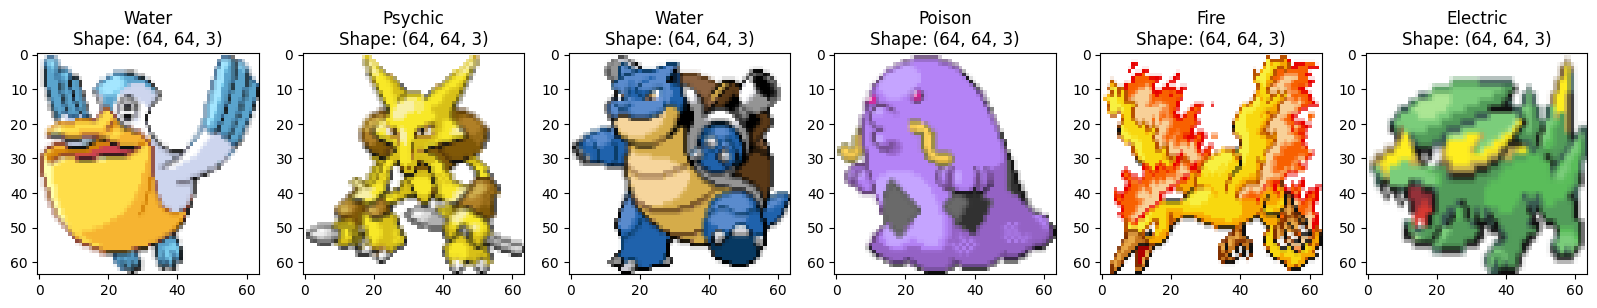

2024-06-15 10:05:08.932460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


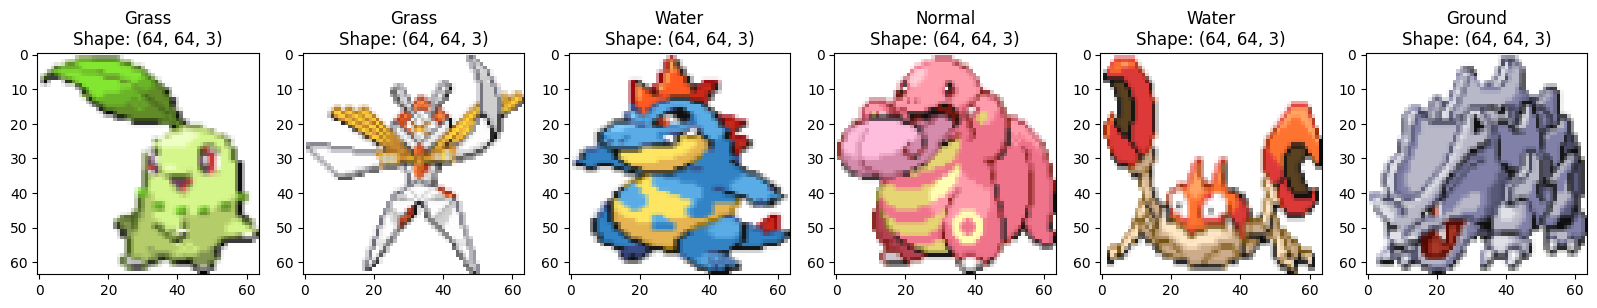

2024-06-15 10:05:09.178324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# train test split
# =====================================================================
train_poke_dataset, test_poke_dataset = tf.keras.utils.split_dataset(
    poke_dataset, left_size=0.95, shuffle=True
)

# Length of the datasets
print(f"- Train size: {len(train_poke_dataset) * BATCH_SIZE} sprites")
print(f"- Test size: {len(test_poke_dataset) * BATCH_SIZE} sprites")

# Plot
visualize.plot_images_batch(train_poke_dataset, 6)
visualize.plot_images_batch(test_poke_dataset, 6)

# 2. Modelo

Definimos el modelo usando la arquitectura **U-Net** y añadiendo las funcionalidades de un modelo de difusión con la clase `DiffusionModel()`.

---

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

## 2.1. Entrenamiento

Entrenamos el modelo con los `EPOCHS` definido como hiperparámetro en el `config.ini` y añadimos la funcionalidad de guardado y muestreo de imágenes durante el entrenamiento a través del callback `DiffusionCallback`.

Epoch 1/500


I0000 00:00:1718445929.297783    3585 service.cc:145] XLA service 0x719ed8002d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718445929.297806    3585 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-15 10:05:29.698784: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1718445930.154457    3585 random_ops.cc:59] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
W0000 00:00:1718445930.183431    3585 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform_1
2024-06-15 10:05:31.055

  1/121 ━━━━━━━━━━━━━━━━━━━━ 1:23:57 42s/step - mae: 1.1168 - loss: 1.9779

I0000 00:00:1718445960.034337    3585 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - mae: 0.7258 - loss: 0.9012

I0000 00:00:1718445980.369458    4869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5', 172 bytes spill stores, 172 bytes spill loads



121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 188ms/step - mae: 0.7244 - loss: 0.8984 - val_loss: 0.2635 - val_mae: 0.3725
Epoch 2/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - mae: 0.3475 - loss: 0.2310 - val_loss: 0.1853 - val_mae: 0.3045
Epoch 3/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - mae: 0.2953 - loss: 0.1756 - val_loss: 0.1516 - val_mae: 0.2707
Epoch 4/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - mae: 0.2670 - loss: 0.1500 - val_loss: 0.1497 - val_mae: 0.2619
Epoch 5/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - mae: 0.2509 - loss: 0.1367 - val_loss: 0.1248 - val_mae: 0.2385
Epoch 6/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - mae: 0.2411 - loss: 0.1284 - val_loss: 0.1220 - val_mae: 0.2352
Epoch 7/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - mae: 0.2329 - loss: 0.1221 - val_loss: 0.1301 - val_mae: 0.2398
Epoch 8/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - mae: 0.2237 - loss: 0.1142 - val_loss: 0.1002 - val_mae: 0.2097
Epoch 9/500
121/121 ━━━━━━━━━━━━━━━━

Sampling sprite...: 100%|██████████| 999/999 [01:23<00:00, 11.89it/s]


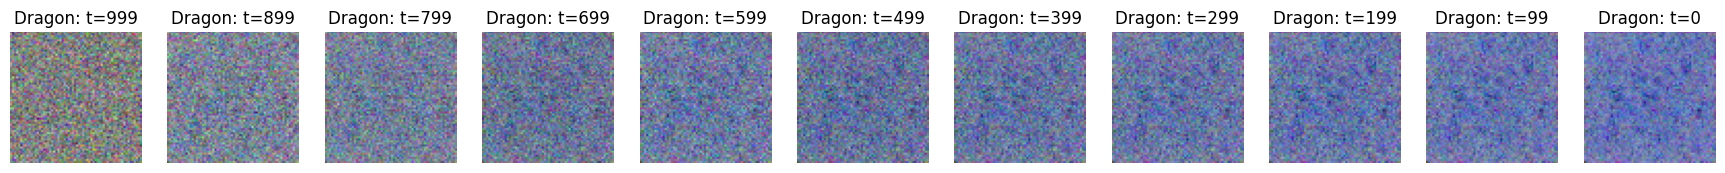

121/121 ━━━━━━━━━━━━━━━━━━━━ 104s 862ms/step - mae: 0.1863 - loss: 0.0899 - val_loss: 0.0727 - val_mae: 0.1655
Epoch 21/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - mae: 0.1803 - loss: 0.0870 - val_loss: 0.0941 - val_mae: 0.1907
Epoch 22/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.1831 - loss: 0.0890 - val_loss: 0.0879 - val_mae: 0.1875
Epoch 23/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - mae: 0.1787 - loss: 0.0845 - val_loss: 0.0823 - val_mae: 0.1765
Epoch 24/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.1765 - loss: 0.0847 - val_loss: 0.0749 - val_mae: 0.1660
Epoch 25/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - mae: 0.1801 - loss: 0.0884 - val_loss: 0.0754 - val_mae: 0.1698
Epoch 26/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - mae: 0.1746 - loss: 0.0828 - val_loss: 0.0907 - val_mae: 0.1805
Epoch 27/500
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - mae: 0.1753 - loss: 0.0846 - val_loss: 0.0943 - val_mae: 0.1847
Epoch 28/500
121/121 ━━━━━━━

In [9]:
# Train the model
# =====================================================================
diff_callback = DiffusionCallback(model, 20, "Dragon")
history = model.fit(
    train_poke_dataset,
    epochs=EPOCHS,
    validation_data=test_poke_dataset,
    callbacks=[diff_callback],
)

## 2.2. Evaluación del modelo

Una vez entrenado el modelo, lo evaluamos gracias al conjunto de testeo que definimos anteriormente. Para evaluar el entrenamiento del modelo se mostrarán la evolución de los valores de la función de perdida y las métricas a lo largo del entrenamiento. Todo ello, para garantizar el correcto entrenamiento del modelo de difusión, evitando su overfitting principalmente.

Y tal y como podemos observar el modelo no sufre de overfitting y ambas funciones tienen a minimizar el error cometido correctamente, por lo que podemos garantizar que el entrenamiento se ha realizado con éxito.

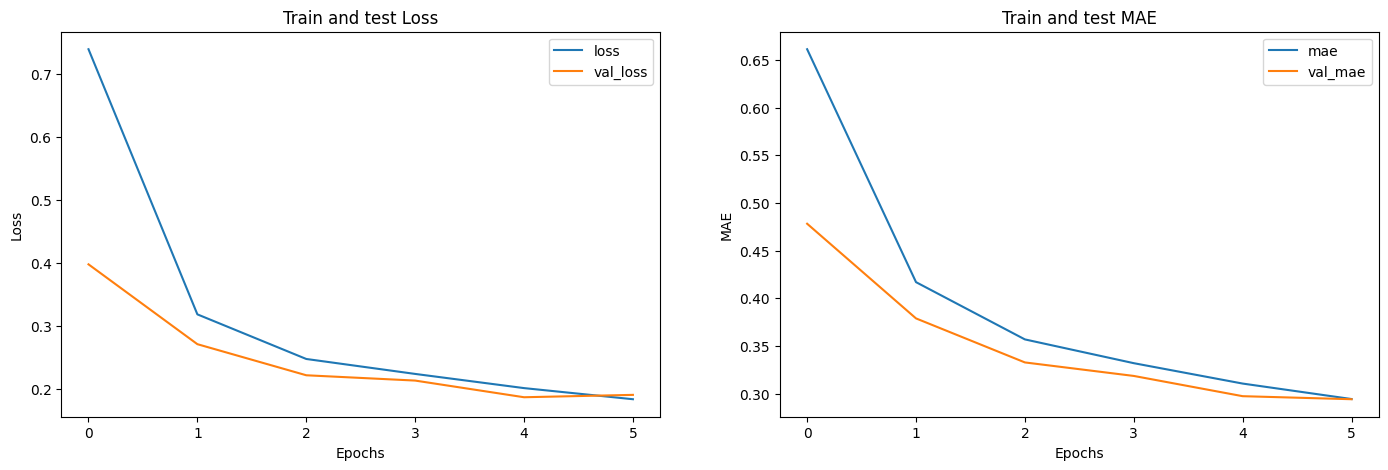

In [8]:
visualize.plot_history(history)

## 2.3. Resultados y guardado del modelo

Finalmente, una vez comprobado el correcto entrenamiento del modelo, procedemos a guardarlo para futuras síntesis de imágenes sin necesidad de estar entrenando de nuevo el modelo. Además, aprovechamos para mostrar la generación de imágenes tras el entrenamiento del modelo.

In [ ]:
# Save and load the model
# =====================================================================
save_path = f"{MODELS_PATH}/diffusion_{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}_epochs{EPOCHS}.weights.h5"
model.save_weights(save_path)

model_loaded = DiffusionModel.load_model(
    save_path,
    u_net,
    IMG_SIZE,
    NUM_CLASSES,
    TIMESTEPS,
    BETA_START,
    BETA_END,
    S,
    SCHEDULER,
)

In [ ]:
# Sample some sprites
# =====================================================================
model_loaded.plot_samples(6)
model_loaded.plot_samples(6)
model_loaded.plot_samples(6, "Fire")
model_loaded.plot_samples(6, "Water")
model_loaded.plot_samples(6, "Grass")
model_loaded.plot_samples(6, "Dragon")

[BACK TO TOP](#top)